In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score as cv
from sklearn.linear_model import LinearRegression
%matplotlib inline


# This is my first stab at a machine learning comp 100% solo

## workflow
- examine dataset
- remove or transform columns with
    1) data leakage (disclosing future info)
    2) non-correlation (doesnt have info about target value)
    3) non-useable format (wrong d-type, need conversion, need cleanup)
    4) incomplete (need processing or to be combined with othe data)
    5) redundancy (columns that have duplicating correlation)
    6) class imbalance (skew too heavy left or right)
- identify missing data
    1) clear rows with too much missing data
    2) drop columns with too many missing values
    3) fill remaining na if possible (impute, mean, mode, etc)
    4) drop rows with unfilled na values
- handle non-numerical data
    1) change numeric values that need conversion (i.e. '10%')
    2) check categorical values to confirm unique values
    3) address date columns (no leakage! year --> age)
    4) use mapping dict for value conversions
    5) clean up strings
    6) use get_dummys for categoricals and drop old column
- normalize all numerical columns 
- test model for hyperparmeter settings
- test different models and grid search hyperparams

- select the best one 
- make test predictions
- submit!

    

In [2]:
raw_data = pd.read_csv('train.csv')
first_cols = raw_data.iloc[:,:18]
second_cols = raw_data.iloc[:, 18:36]
third_cols = raw_data.iloc[:, 36:54]
fourth_cols = raw_data.iloc[:, 54:72]
fifth_cols = raw_data.iloc[:, 72:]
target = raw_data['SalePrice'].copy()

## looking into the columns in the first group 

In [3]:
# searching for null values
finding_nulls = first_cols.info()
# lots in 'Alley' and a few in 'LotFrontage'

# 'Alley' is categorical so I will fill in the NA to see what it is worth
Alley_null_count = raw_data['Alley'].isnull().sum()
alley_values = raw_data['Alley'].value_counts()
raw_data['Alley'].fillna(value='none', inplace=True)
alley_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            1460 non-null   int64  
 1   MSSubClass    1460 non-null   int64  
 2   MSZoning      1460 non-null   object 
 3   LotFrontage   1201 non-null   float64
 4   LotArea       1460 non-null   int64  
 5   Street        1460 non-null   object 
 6   Alley         91 non-null     object 
 7   LotShape      1460 non-null   object 
 8   LandContour   1460 non-null   object 
 9   Utilities     1460 non-null   object 
 10  LotConfig     1460 non-null   object 
 11  LandSlope     1460 non-null   object 
 12  Neighborhood  1460 non-null   object 
 13  Condition1    1460 non-null   object 
 14  Condition2    1460 non-null   object 
 15  BldgType      1460 non-null   object 
 16  HouseStyle    1460 non-null   object 
 17  OverallQual   1460 non-null   int64  
dtypes: float64(1), int64(4), obj

Grvl    50
Pave    41
Name: Alley, dtype: int64

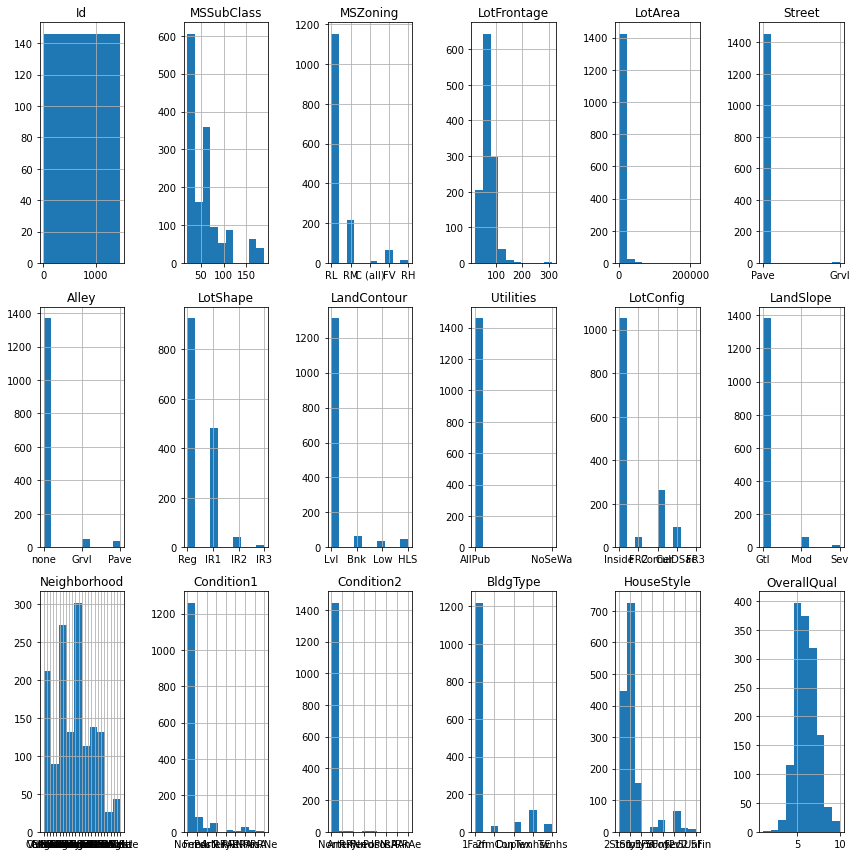

In [4]:
#plot out some histagrams and see what our distributions look like

cols = list(first_cols.columns)

fig = plt.figure(figsize=(12,12))
for i, column in enumerate(cols):
    i = i+1
    plt.subplot(3,6,i)
    raw_data[column].hist()
    plt.title(column)

plt.tight_layout()
plt.show()

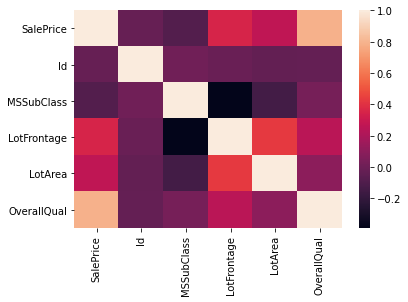

In [5]:
# correlations df for heatmap
corr_df = raw_data[['SalePrice']+cols].corr()
sns.heatmap(corr_df)

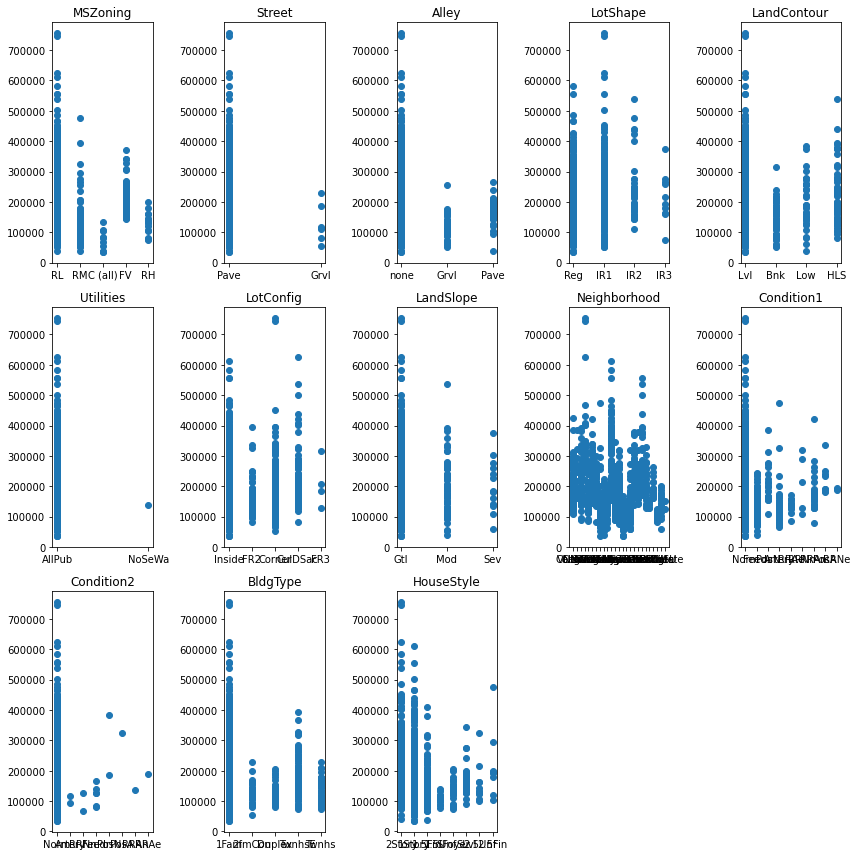

In [6]:
#plot out some relationships for the categorical to price. Most of the categorical distributions are whack.

c_cols = list(first_cols.select_dtypes(include='object').columns)


fig = plt.figure(figsize=(12,12))
for i, column in enumerate(c_cols):
    i = i+1
    plt.subplot(3,5,i)
    plt.scatter(raw_data[column], target)
    #raw_data[column].hist()
    plt.title(column)

plt.tight_layout()
plt.show()


In [7]:
import ipywidgets as widgets

@widgets.interact(x=(0,12,1), )
def hist_list(x=0):
    c_cols = list(first_cols.select_dtypes(include='object').columns)
    fig = plt.figure(figsize=(6,6))
    y = c_cols[x]
    name = raw_data[y]
    plt.scatter(name, raw_data['SalePrice'])
    plt.title(y)

    plt.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=0, description='x', max=12), Output()), _dom_classes=('widget-interact',…

## looking into the neighborhood column

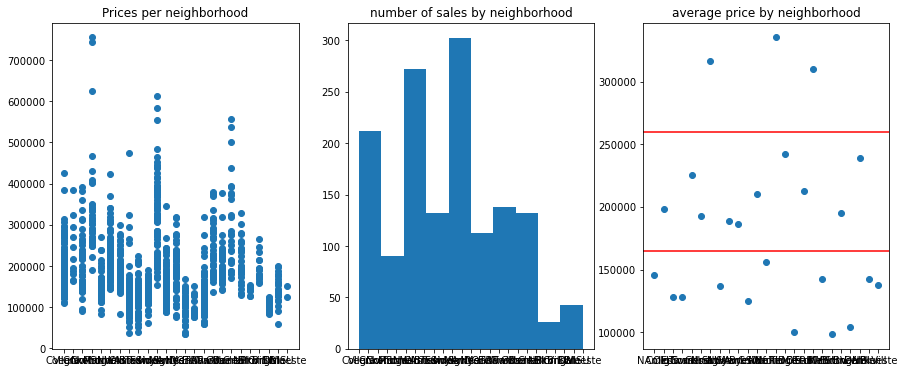

In [8]:
hoodz = pd.DataFrame({'home_count': raw_data['Neighborhood'].value_counts()})
grouped_hoods = raw_data.groupby(by='Neighborhood', axis=0)
hoodz['hood_means'] = pd.Series(data=grouped_hoods["SalePrice"].apply(np.mean), name='mean_price')
total_mean = raw_data['SalePrice'].mean()
hoodz['mean_difference'] = hoodz['hood_means'] - total_mean
hoodz['normalized_difference'] = (hoodz['mean_difference'] - hoodz['mean_difference'].min()) / (hoodz['mean_difference'].max() - hoodz['mean_difference'].min())
hoodz

fig  = plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.scatter(raw_data['Neighborhood'], raw_data['SalePrice'])
plt.title('Prices per neighborhood')
plt.subplot(1,3,2)
plt.hist(raw_data['Neighborhood'])
plt.title('number of sales by neighborhood')
plt.subplot(1,3,3)
grouped_hoods = raw_data.groupby(by='Neighborhood', axis=0)
neighborhood_mean_price = pd.Series(data=grouped_hoods["SalePrice"].apply(np.mean), name='mean_price')
plt.axhline(260000, color='r')
plt.axhline(165000, color = 'r')
plt.scatter(hoodz['hood_means'].index, hoodz['hood_means'])
plt.title('average price by neighborhood')
plt.show()



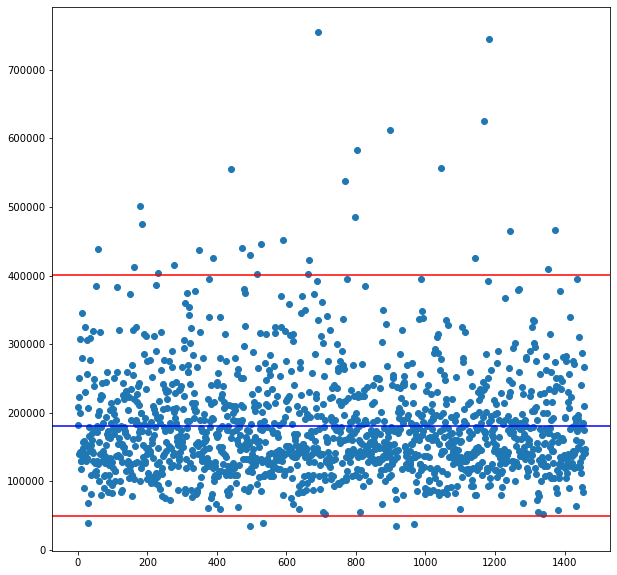

In [9]:
# scatter plot of all house prices with lines for upper boundary, lower boundary, and overall mean price

fig=plt.figure(figsize=(10,10))
plt.scatter(raw_data.index, raw_data['SalePrice'])
plt.axhline(401000, color='r')
plt.axhline(total_mean, color='b')
plt.axhline(50000, color='r')

plt.show()

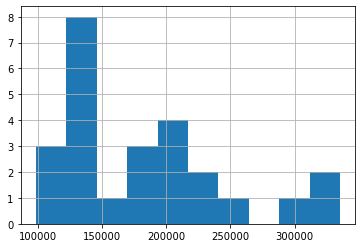

In [10]:
# using these histograms, i think its clear, I'll try three categories- above $300K, below $160, and inbetween
hoodz['hood_means'].hist()

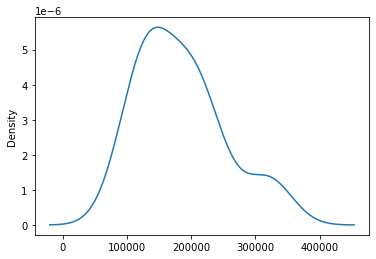

In [11]:
hoodz['hood_means'].plot.kde()

### dealing with Neighborhoods
Ive spent a lot of time looking at neighborhoods already and Im still not convinced either to drop it or keep it. I thinkanother way to categorize it might be to create a new categorical tier of "Area" - "nice"=$300k+, "average", "poor"=$160k. After further investigation, this seems like a good idea for now, if it doesnt pan out then I can delete it later. but below is the code to make a column. I think what I need to do is make two dummy columns, prob "nice" and "poor" and let the third column be implied. I forget why, but thats what dummy columns are supposed to do. below is the code.

In [12]:
# Ive spent a lot of time looking at neighborhoods already and Im still not convinced either to drop it or keep it. I think
# another way to categorize it might be to create a new categorical tier of "Area" - "nice"=$300k+, "average", "poor"=$160k-

nice_hoods = list(hoodz[hoodz['hood_means'] > 300000].index)
poor_hoods = list(hoodz[hoodz['hood_means'] < 160000].index)
average_hoods = list(hoodz[(hoodz['hood_means'] < 300000) & (hoodz['hood_means'] > 160000)].index)

## looking into condition1 and condition2

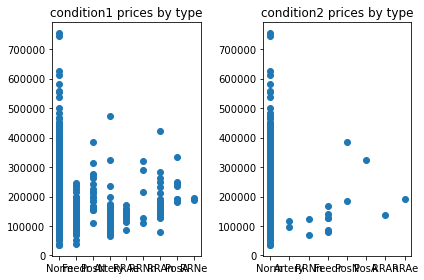

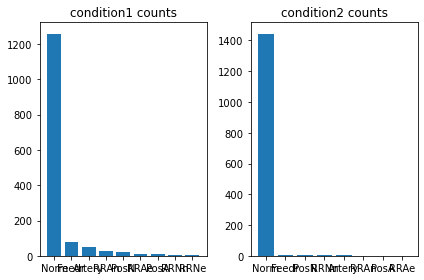

In [13]:
plt.subplot(121)
plt.scatter(raw_data['Condition1'], raw_data['SalePrice'])
plt.title('condition1 prices by type')

plt.subplot(122)
plt.scatter(raw_data['Condition2'], raw_data['SalePrice'])
plt.title('condition2 prices by type')
plt.tight_layout()

plt.show()

con_1 = raw_data['Condition1'].value_counts()
con_2 = raw_data['Condition2'].value_counts()
plt.subplot(121)
plt.bar(con_1.index, con_1)
plt.title('condition1 counts')
plt.subplot(122)
plt.bar(con_2.index, con_2)
plt.title('condition2 counts')
plt.tight_layout()

plt.show()


The condition categories are way too skewed toward a single value and the other values dont seem to have much distinguishing value for sale price. gonna go ahead and add these to the drop list.

## looking into building type and house style

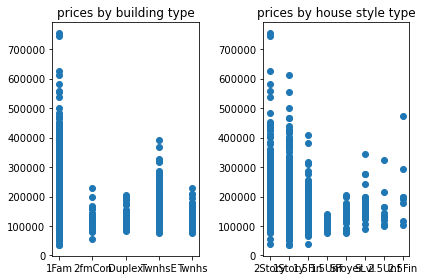

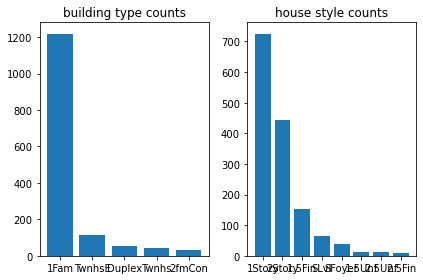

In [14]:
plt.subplot(121)
plt.scatter(raw_data['BldgType'], raw_data['SalePrice'])
plt.title('prices by building type')

plt.subplot(122)
plt.scatter(raw_data['HouseStyle'], raw_data['SalePrice'])
plt.title('prices by house style type')
plt.tight_layout()

plt.show()

btype = raw_data['BldgType'].value_counts()
hstyle = raw_data['HouseStyle'].value_counts()
plt.subplot(121)
plt.bar(btype.index, btype)
plt.title('building type counts')
plt.subplot(122)
plt.bar(hstyle.index, hstyle)
plt.title('house style counts')
plt.tight_layout()

plt.show()

neither of these columns seem to have much value either. add to drop list.

## This is the function part of the first few columns group
- Im dropping 'ID', 'MSSubClass','LotFrontage' & 'LotArea' for low correlation (<.4)
- dropping 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'HouseStyle', 'Condition1', 'Condition2'and 'BldgType' because I dont think those categorical columns have enough information to be worthwhile.
- I'm converting the 'Neighborhood' column into a categorical with 3 tiers. I will create dummy columns for the high-end and low-end neighborhoods and let the middle tier be implied, then dropping the original column.

In [15]:
# dropping unwanted numerical columns
def drop_unwanted_numericals(df):
    drop_cols = ['Id', 'MSSubClass', 'LotFrontage', 'LotArea']
    df = df.drop(labels=drop_cols, axis=1)
    return df
# dropping unwanted categorical columns
def drop_unwanted_categoricals(df):
    drop_cols = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',\
             'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType',\
            'HouseStyle']
    df = df.drop(labels=drop_cols, axis=1)
    return df

# creating neighborhood:area dictionary
neighborhood_dict = {}
for hood in hoodz.index:
    if hood in nice_hoods:
        neighborhood_dict[hood] = 'nice_area'
    elif hood in poor_hoods:
        neighborhood_dict[hood] = 'poor_area'
    else: neighborhood_dict[hood] = 'average_area'

# map areas onto neighborhood column
def bin_neighborhoods(df):
    df['Neighborhood'] = df['Neighborhood'].replace(to_replace=neighborhood_dict)
    return df

#do a get dummies for these cols
dummy_cols = ['Neighborhood']

data = drop_unwanted_numericals(raw_data)
data = drop_unwanted_categoricals(data)
data = bin_neighborhoods(data)

data.head()

,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,average_area,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,average_area,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,average_area,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,average_area,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,nice_area,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


That's it for the first group of columns. Basically I dropped all of the columns except Neighborhood and OverallQual. Im leaving OverallQual alone for now, but I reclassified the Neighborhood column into 3 groups according to mean neighborhood prices. Later, I will define a single function that will create all the dummy columns for the remaining categorical.

## looking into the columns in the second group

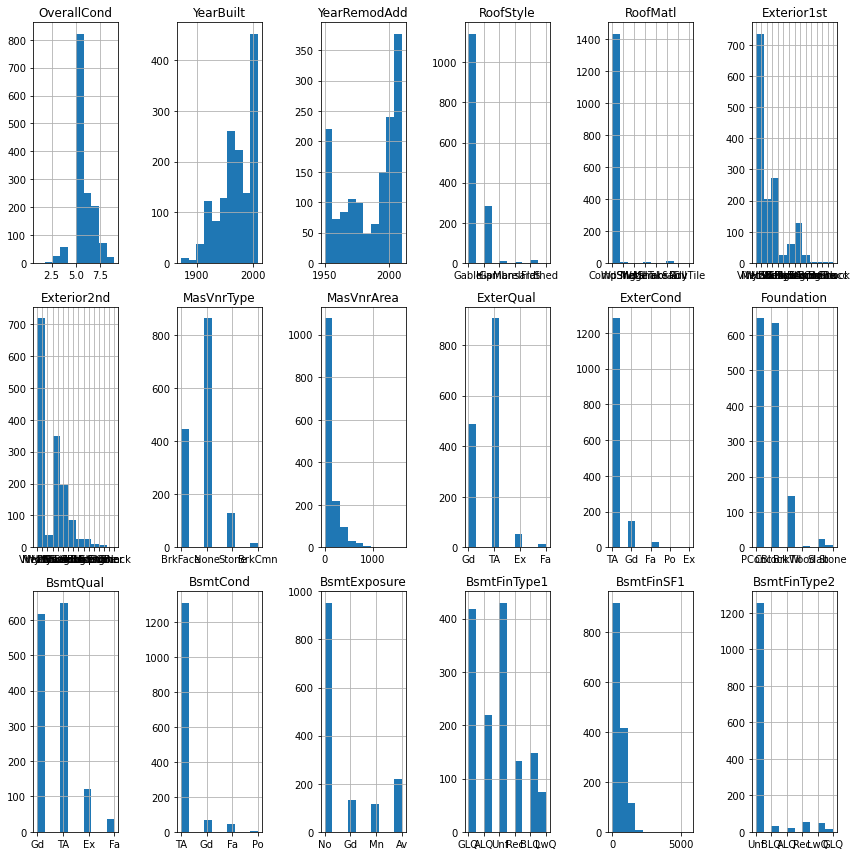

In [16]:
# initial historgam plot for second set of columns

cols = list(second_cols.columns)

fig = plt.figure(figsize=(12,12))
for i, column in enumerate(cols):
    i = i+1
    plt.subplot(3,6,i)
    raw_data[column].hist()
    plt.title(column)

plt.tight_layout()
plt.show()

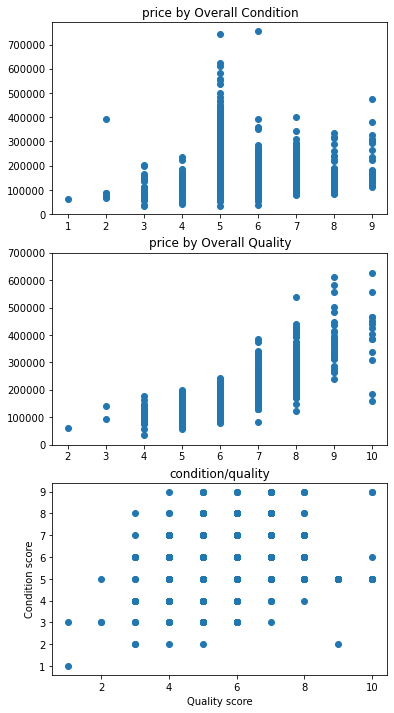

In [17]:
fig = plt.figure(figsize=(6,12))

plt.subplot(311)
plt.scatter(raw_data['OverallCond'], raw_data['SalePrice'])
plt.title('price by Overall Condition')

plt.subplot(312)
f = raw_data['OverallCond']==5
plt.scatter(raw_data['OverallQual'][f], raw_data['SalePrice'][f])
plt.title('price by Overall Quality')
plt.ylim(0,700000)

plt.subplot(313)
plt.scatter(raw_data['OverallQual'], raw_data['OverallCond'])
plt.title('condition/quality')
plt.xlabel('Quality score')
plt.ylabel('Condition score')

plt.show()

it seems like overall Condition isnt exactly the same as overall quality, so I will leave it in for now and we can run some tests with and without it later. just earmark it for now tho.

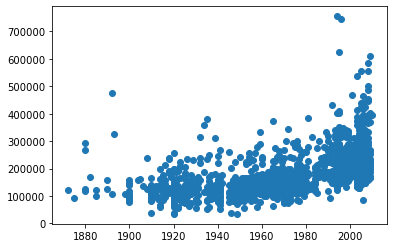

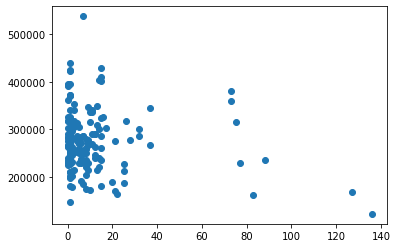

In [18]:
plt.scatter(raw_data.YearBuilt, raw_data.SalePrice)
plt.show()
raw_data['Age'] = raw_data.YrSold - raw_data.YearBuilt
f=raw_data['OverallQual']==8
plt.scatter(raw_data['Age'][f], raw_data['SalePrice'][f])
plt.show()
#this age number kinda seems worthless, but I'll make this
#transformation and then see how it goes

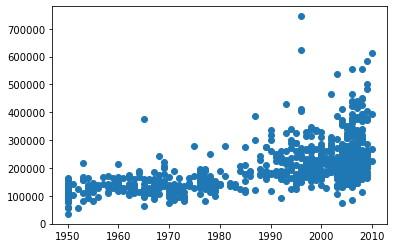

In [19]:
# looking into 'YearRemodelAdd'
f=raw_data['OverallCond']==5
plt.scatter(raw_data['YearRemodAdd'][f], raw_data['SalePrice'][f])
# seems about the same as 'year built'. I'll do the same conversion and deal with it later
raw_data['YrsSinceRemod'] = raw_data['YrSold'] - raw_data['YearRemodAdd']


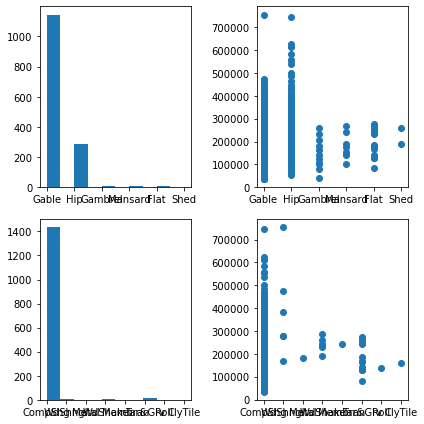

In [20]:
fig = plt.figure(figsize=(6,6))
plt.subplot(221)
plt.hist(second_cols['RoofStyle'])
plt.subplot(222)
plt.scatter(raw_data['RoofStyle'], target)
plt.subplot(223)
plt.hist(second_cols['RoofMatl'])
plt.subplot(224)
plt.scatter(raw_data['RoofMatl'], target)
plt.tight_layout()

plt.show()

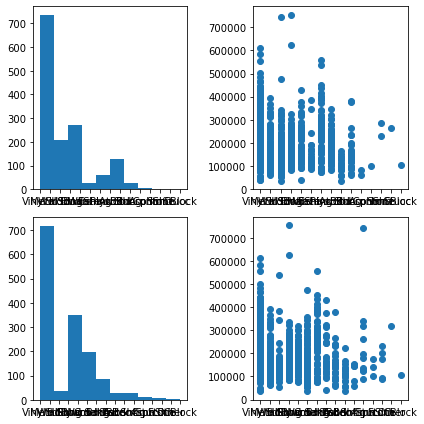

In [21]:
fig = plt.figure(figsize=(6,6))
plt.subplot(221)
plt.hist(second_cols['Exterior1st'])
plt.subplot(222)
plt.scatter(raw_data['Exterior1st'], target)
plt.subplot(223)
plt.hist(second_cols['Exterior2nd'])
plt.subplot(224)
plt.scatter(raw_data['Exterior2nd'], target)
plt.tight_layout()

plt.show()

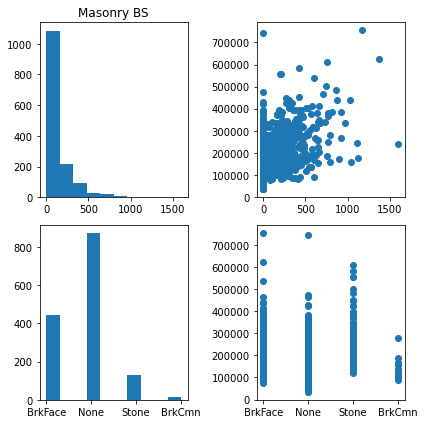

In [22]:
second_cols.MasVnrArea.fillna(value=0, inplace=True)
second_cols['MasVnrType'].fillna(value='None', inplace=True)


fig = plt.figure(figsize=(6,6))
plt.subplot(221)
plt.title('Masonry BS')
plt.hist(second_cols['MasVnrArea'])
plt.subplot(222)
plt.scatter(raw_data['MasVnrArea'], target)
plt.subplot(223)
plt.hist(second_cols['MasVnrType'])
plt.subplot(224)
plt.scatter(second_cols['MasVnrType'], target)
plt.tight_layout()

plt.show()

#this column doesnt seem to matter one bit. not enough points and doesnt show influence on price


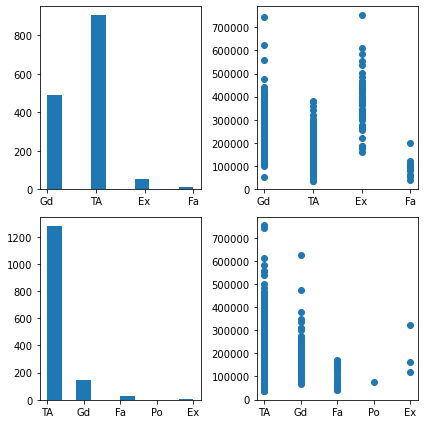

In [23]:
fig = plt.figure(figsize=(6,6))
plt.subplot(221)
plt.hist(second_cols['ExterQual'])
plt.subplot(222)
plt.scatter(raw_data['ExterQual'], target)
plt.subplot(223)
plt.hist(second_cols['ExterCond'])
plt.subplot(224)
plt.scatter(raw_data['ExterCond'], target)
plt.tight_layout()

plt.show()

#exterior condition is far too skewed to be useable
#and I just dont think that exterior qual is going to be fruitful either

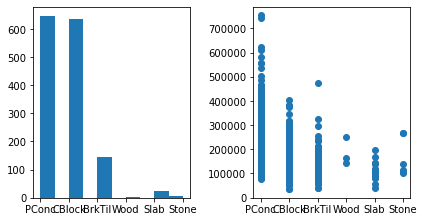

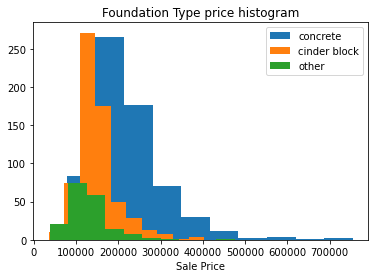

In [24]:
fig = plt.figure(figsize=(6,6))
plt.subplot(221)
plt.hist(second_cols['Foundation'])
plt.subplot(222)
plt.scatter(raw_data['Foundation'], target)

plt.tight_layout()

plt.show()

plt.hist(raw_data['SalePrice'][raw_data['Foundation']=='PConc'], histtype='stepfilled', label='concrete')
plt.hist(raw_data['SalePrice'][raw_data['Foundation']=='CBlock'], histtype='stepfilled', label='cinder block')
plt.hist(raw_data['SalePrice'][(raw_data['Foundation']!='CBlock') & (raw_data['Foundation']!='PConc')], histtype='stepfilled', label='other')
plt.legend()
plt.title('Foundation Type price histogram')
plt.xlabel('Sale Price')
plt.ylabel('')

plt.show()







Looks like foundation is a good case to divide the dataset into 3 categorical types. the category distribution isnt too heavily skewed and the categories seem to have relevant price correlation. 

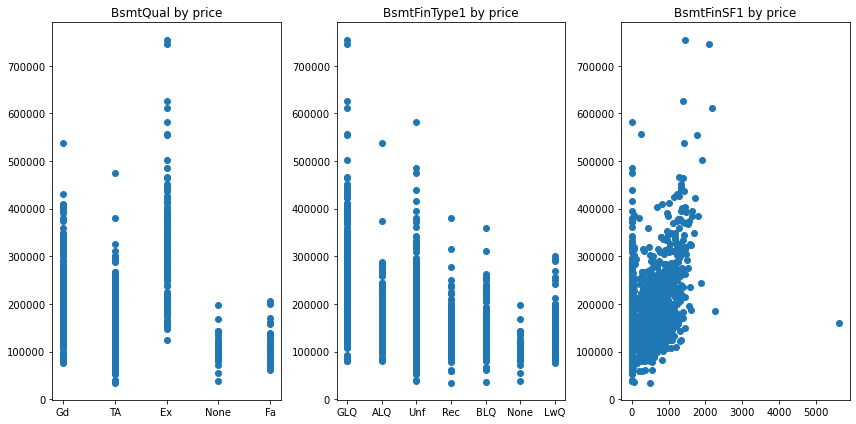

GLQ 235413.72009569377
ALQ 161573.06818181818
Unf 170670.57674418605
Rec 146889.24812030076
BLQ 149493.6554054054
None nan
LwQ 151852.7027027027


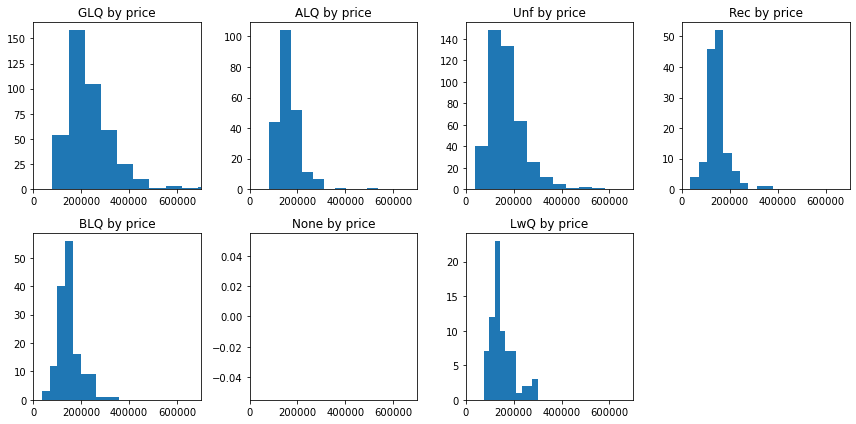

In [25]:
# basement condition, basement exposure, basement fin type2 dont have enough variation, so they get dropped.
# I just dont like the BsmtFinType1 column. dropping it.

basement_cols = ['BsmtQual', 'BsmtFinType1', 'BsmtFinSF1',]

# gotta remember to fill the na values
second_cols.fillna(value='None', inplace=True)

fig=plt.figure(figsize=(12,6))
for i,column in enumerate(basement_cols):
    plt.subplot(1,3,i+1)
    plt.scatter(second_cols[column], target)
    plt.title(column + ' by price')
    plt.tight_layout()
plt.show()    
    
# gotta remember to fill the na values
# second_cols.fillna(value='None', inplace=True)

fig=plt.figure(figsize=(12,6))
vals = second_cols['BsmtFinType1'].unique()
for i, category in enumerate(vals):
    plt.subplot(2,4,i+1)
    plt.hist(raw_data['SalePrice'][raw_data['BsmtFinType1']==category])
    print(category, raw_data['SalePrice'][raw_data['BsmtFinType1']==category].mean())
    plt.title(category + ' by price')
    plt.xlim(0,700000)
    plt.tight_layout()
plt.show() 




In [26]:
# these two rows (raw_data.iloc[[523, 1298]]) seem to screw up the data for basement sqft.
# They are huge sqft and low price and will skew the regression

raw_data.drop(labels=[523, 1298],axis=0, inplace=True)


basement condition, basement exposure, basement fin type2 dont have enough variation, so they get dropped 

## Second columns function part
- transforming 'YearBuilt' into 'Age'. Still shit but at least it makes linear sense
- pretty much the same for 'YearRemodAdd'
- drop the roofing columns, the exterior columns, masonry columns, exterior rating columns,BsmtFinType1
- transforming the 'Foundation' Values into 3 categories and then apply dummy labels later
- dropping a bunch of basement columns, filling na vals, and dropping a couple outliers in train data


In [27]:
# turning 'YearBuilt' into Age
def year_to_age(df):
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df = df.drop('YearBuilt', axis=1)
    return df

# turning 'YearRemodAdd' int 'YrsSinceRemod'
def year_remod_to_yrs_since(df):
    df['YrsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
    df = df.drop('YearRemodAdd', axis=1)
    return df

# dropping unwanted categoricals
def drop_unwanted_categoricals_2(df):
    drop_cols = ['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',\
                 'MasVnrArea', 'MasVnrType', 'ExterCond', 'ExterQual', \
                 'BsmtFinType1', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2']
    df = df.drop(labels=drop_cols, axis=1)
    return df

# combining foundation categoricals
def combine_foundation_categories(df):
    mask = (df['Foundation']!='PConc') & (df['Foundation']!='CBlock')
    df.loc[mask, 'Foundation'] = 'Other'
    return df

data = year_to_age(data)
data = year_remod_to_yrs_since(data)
data = drop_unwanted_categoricals_2(data)
data = combine_foundation_categories(data)

#dropping the outlier row on the working train data set
data.drop(labels=[523, 1298],axis=0, inplace=True)
data.head()


,Neighborhood,OverallQual,OverallCond,Foundation,BsmtQual,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age,YrsSinceRemod
0,average_area,7,5,PConc,Gd,706,0,150,856,GasA,...,NaN,NaN,0,2,2008,WD,Normal,208500,5,5
1,average_area,6,8,CBlock,Gd,978,0,284,1262,GasA,...,NaN,NaN,0,5,2007,WD,Normal,181500,31,31
2,average_area,7,5,PConc,Gd,486,0,434,920,GasA,...,NaN,NaN,0,9,2008,WD,Normal,223500,7,6
3,average_area,7,5,Other,TA,216,0,540,756,GasA,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,91,36
4,nice_area,8,5,PConc,Gd,655,0,490,1145,GasA,...,NaN,NaN,0,12,2008,WD,Normal,250000,8,8


## Looking into the Third set of columns

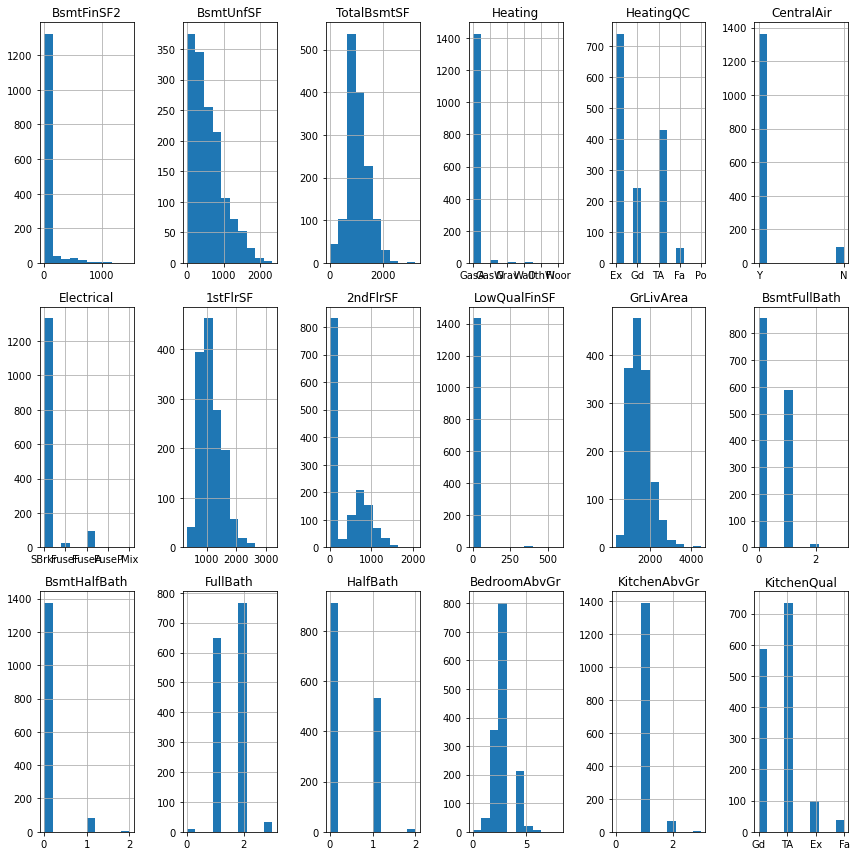

In [28]:
# initial historgam plot for third set of columns

cols = list(third_cols.columns)

fig = plt.figure(figsize=(12,12))
for i, column in enumerate(cols):
    i = i+1
    plt.subplot(3,6,i)
    raw_data[column].hist()
    plt.title(column)

plt.tight_layout()
plt.show()

In [29]:
#just looking at the histogram distributions I can already drop several columns for lack of variabilty.

drop_cols = ['BsmtFinSF2', 'Heating', 'Electrical', 'CentralAir']

BsmtFinSF2 0.19895609430836586
BsmtUnfSF 0.1692173509242535
TotalBsmtSF 0.6539096096084349
1stFlrSF 0.6315303791989998
2ndFlrSF 0.6782457369126409
LowQualFinSF 0.3000750165550133
GrLivArea 0.7349681645359343
BsmtFullBath 0.016249794374167056
BsmtHalfBath -0.028834567185481712
FullBath 0.5761544398801188
HalfBath -0.08467422547563816
BedroomAbvGr 0.18096628867218173
KitchenAbvGr -0.13924068155001332


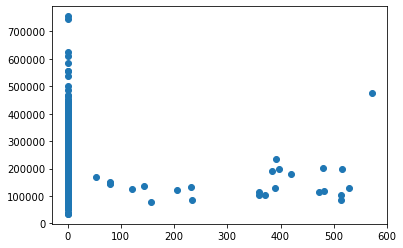

In [30]:
#looking into numericals
plt.scatter(raw_data['LowQualFinSF'], raw_data['SalePrice'])
cols = list(third_cols.columns)
corr_df = raw_data[cols + ['SalePrice']].corr()
corr_list = list(raw_data[cols + ['SalePrice']].corr().index)
good_corr_list = list(corr_df[corr_df['SalePrice'] > .4].index)
        
for column in cols:
    try:
        col_filter = raw_data[column]>0
        positive_df = raw_data[[column, "SalePrice"]][col_filter].corr()
        corr_value = positive_df.loc[column, 'SalePrice']
        print(column, corr_value)
    except:
        pass

n_drop_cols = ['BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'KitchenAbvGr', 'BedroomAbvGr']
price_check_cols = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']

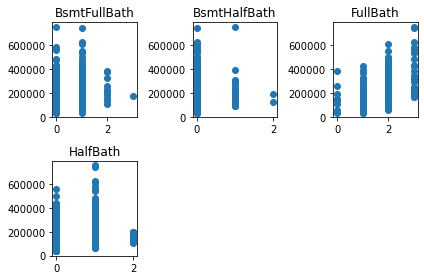

In [31]:
for i,column in enumerate(price_check_cols):
    plt.subplot(2,3,i+1)
    plt.scatter(raw_data[column], raw_data['SalePrice'])
    plt.title(column)

plt.tight_layout()
plt.show()

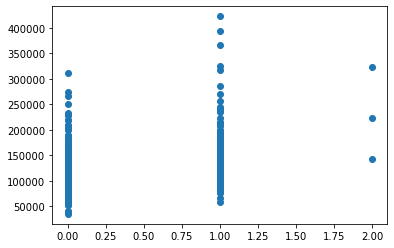

In [32]:
# it seems like basement bath does have additive value, BUT... I want to try to just add them all up
mask = raw_data['FullBath']==1
plt.scatter(raw_data['BsmtFullBath'][mask], raw_data['SalePrice'][mask])

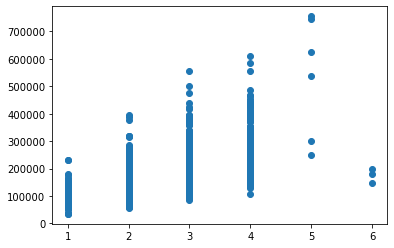

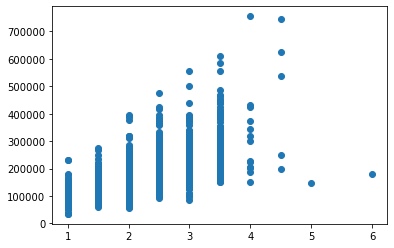

In [33]:
raw_data['TotalBaths'] = raw_data['BsmtFullBath'] + raw_data['BsmtHalfBath'] + raw_data['FullBath'] + raw_data['HalfBath']
raw_data["TB.5"] =  raw_data['BsmtFullBath'] + (raw_data['BsmtHalfBath']*.5) + raw_data['FullBath'] + (raw_data['HalfBath']*.5)

plt.scatter(raw_data["TotalBaths"], raw_data['SalePrice'])
plt.show()
plt.scatter(raw_data["TB.5"], raw_data['SalePrice'])
plt.show()

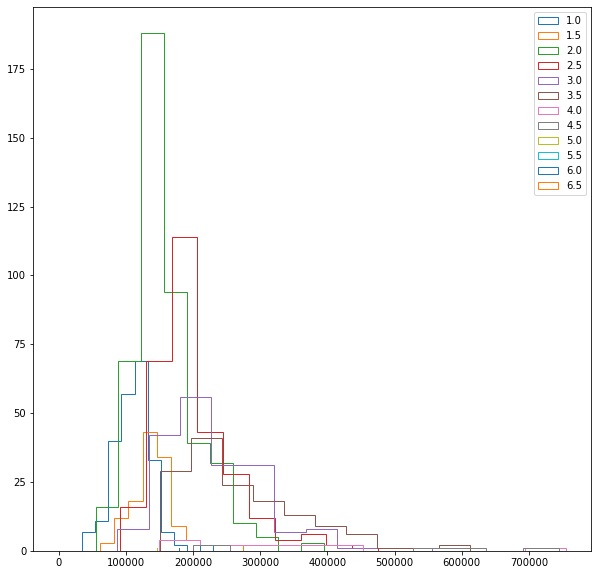

-----TB.5 means------


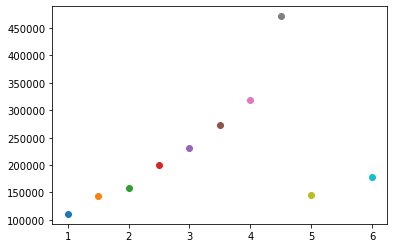

-----total bath means -----


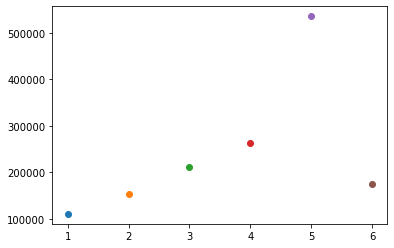

In [34]:
r = np.arange(1,7,.5)
fig=plt.figure(figsize=(10,10))
for i in r:
    mask = raw_data['TB.5']==i
    plt.hist(raw_data["SalePrice"][mask], label=i, histtype='step')
    plt.legend()
plt.show()
print('-----TB.5 means------')
for i in r:
    mask = raw_data['TB.5']==i
    try: 
        plt.scatter(i, int(raw_data["SalePrice"][mask].mean()))
    except: pass
plt.show()

print('-----total bath means -----')
for i in r:
    mask = raw_data['TotalBaths']==i
    try: plt.scatter(i, int(raw_data["SalePrice"][mask].mean()))
    except: pass


In [35]:
raw_data[['TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Neighborhood']][raw_data['TB.5']>=5]

# right now it looks like there are only 2 or 3 real outliers here. so I think we will go with TB.5 but we'll see
# also the outliers are in the poorest neighborhood, so not sure how that effects things




,TotalBsmtSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,Neighborhood
738,1200,1200,3,0,3,0,Edwards
921,1272,2200,2,0,2,2,Edwards


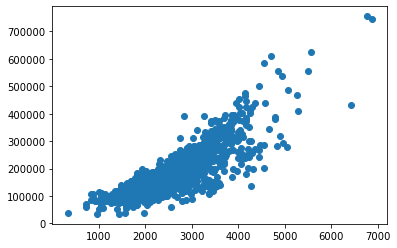

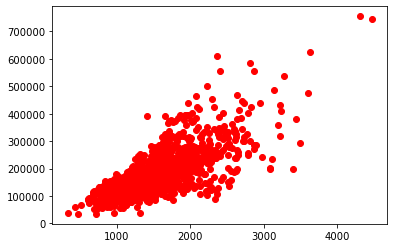

In [36]:
cols
c = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']
# this confirms that 'GrLivArea' is the sum of first floor and second floor sqft
mask = raw_data['GrLivArea'] - raw_data['1stFlrSF'] - raw_data['2ndFlrSF']
non_equal_rows = raw_data[raw_data['GrLivArea'] != raw_data['1stFlrSF'] + raw_data['2ndFlrSF']].copy()
non_equal_rows['difference'] = non_equal_rows['GrLivArea'] - non_equal_rows['1stFlrSF'] - non_equal_rows['2ndFlrSF']
non_equal_rows[['difference', 'LowQualFinSF']]
# So GrLivArea is the sum of first and second floors less low quality space.

# seeing how it adds up if I add the basement sqft
raw_data['TotalSqft'] = raw_data['1stFlrSF'] + raw_data['2ndFlrSF'] + raw_data['TotalBsmtSF'] 
mask = raw_data['LowQualFinSF']>0
plt.scatter(raw_data['TotalSqft'], raw_data['SalePrice'])
plt.show()
plt.scatter(raw_data['GrLivArea'], raw_data['SalePrice'], color='r')
plt.show()

#thats great! it really seems to tighten up that relationship

C:\Users\nate\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


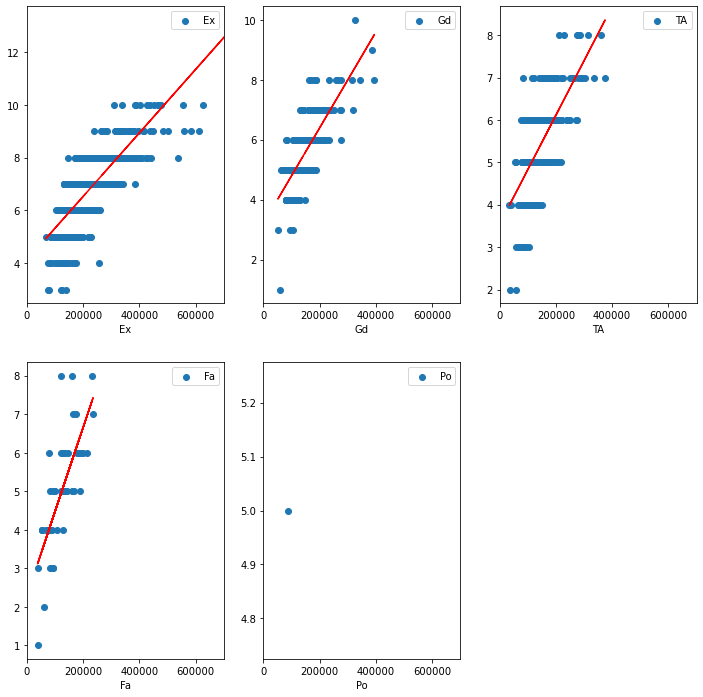

In [37]:
# plotting out the Heating QC column
values = list(raw_data['HeatingQC'].unique())

fig = plt.figure(figsize=(12,12))
for i, values in enumerate(values):
    plt.subplot(2,3,i+1)
    mask = raw_data['HeatingQC']== values
    x = raw_data['SalePrice'][mask]
    y = raw_data['OverallQual'][mask]
    plt.scatter(x, y, label=values)
    plt.xlabel(values)
    plt.xlim(0,700000)
    plt.legend()
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, color= 'r')
    
plt.show()

# I really would not have thought this category would make a difference, but this regression line sold me
# Im doing one  binary category for excellent heating

In [38]:
heat_qc_values = list(raw_data['HeatingQC'].unique())
new_col_values = [1,0,0,0,0]
heat_qc_dict = dict(zip(heat_qc_values, new_col_values))

heat_qc_dict

{'Ex': 1, 'Gd': 0, 'TA': 0, 'Fa': 0, 'Po': 0}

78.05017732817575


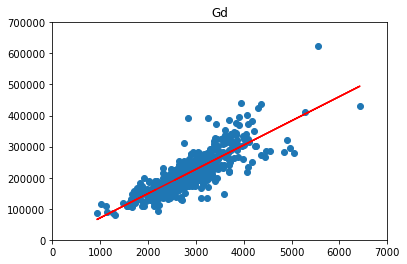

44.3809303968131


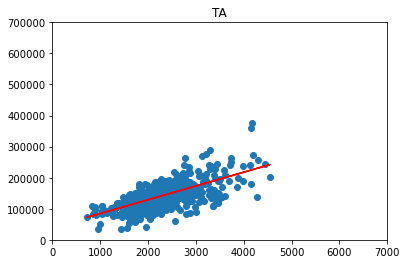

118.12849218746157


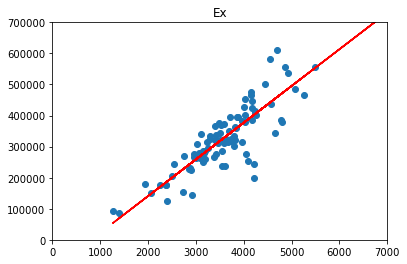

37.554864907989355


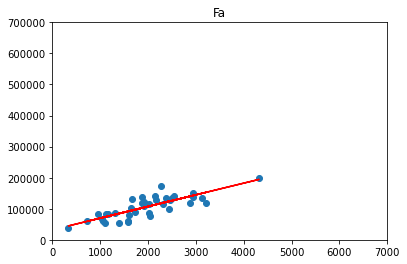

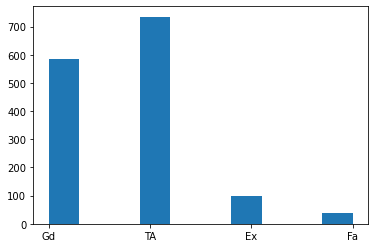

In [39]:
k_vals = list(raw_data['KitchenQual'].unique())

for val in k_vals:
    mask = raw_data['KitchenQual']==val
    x= raw_data['TotalSqft'][mask]
    y= raw_data['SalePrice'][mask]
    plt.scatter(x, y)
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, color= 'r')
    plt.ylim(0,700000)
    plt.xlim(0,7000)
    print(m)
    plt.title(val)
    plt.show()

# not the best, but maybe we just do values for 'Gd' and 'Ex'
plt.hist(raw_data['KitchenQual'])
plt.show()

## Third column function part
- dropping a bunch of columns that dont have either correlation or variation
- taking all the bathroom columns add adding up. half baths =.5 for now
- adding up all the square footage
- make binary column for 'Exellent heating'
- make Kitchen quality distinctions


In [40]:
# adding up the bathrooms
def combine_baths(df):
    df["CombinedBaths"] =  df['BsmtFullBath'] + (df['BsmtHalfBath']*.5) + df['FullBath'] + (df['HalfBath']*.5)
    df = df.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], axis=1)
    return df

# dropping unwanted columns
def drop_cols(df):
    df = df.drop(labels=['BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'KitchenAbvGr', 'BedroomAbvGr', 'BsmtFinSF2',\
                         'Heating', 'CentralAir', 'Electrical', 'GrLivArea'], axis=1)
    return df

# adding up all the square footage
def adding_sqft(df):
    df['TotalSqft'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']
    df = df.drop(['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF'], axis=1)
    return df

# create binary column for excellent heating
heat_qc_values = list(raw_data['HeatingQC'].unique())
new_col_values = [1,0,0,0,0]
heat_qc_dict = dict(zip(heat_qc_values, new_col_values))

def exc_heating(df):
    df['ExcHeating'] = df['HeatingQC'].replace(to_replace=heat_qc_dict)
    df = df.drop(['HeatingQC'], axis=1)
    return df

# create "kitchen quality" cols for good and excellent
def kitchen_classifier(df):
    df['ExcKitchen'] = 0
    df['GoodKitchen'] = 0
    df.loc[df['KitchenQual']=='Gd','GoodKitchen'] = 1
    df.loc[df['KitchenQual']=='Ex','ExcKitchen'] = 1
    df = df.drop(labels='KitchenQual', axis=1)
    return df

data = combine_baths(data)
data = drop_cols(data)
data = adding_sqft(data)
data = exc_heating(data)
data = kitchen_classifier(data)

data.head()


,Neighborhood,OverallQual,OverallCond,Foundation,BsmtQual,BsmtFinSF1,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,...,SaleType,SaleCondition,SalePrice,Age,YrsSinceRemod,CombinedBaths,TotalSqft,ExcHeating,ExcKitchen,GoodKitchen
0,average_area,7,5,PConc,Gd,706,8,Typ,0,NaN,...,WD,Normal,208500,5,5,3.5,2566,1,0,1
1,average_area,6,8,CBlock,Gd,978,6,Typ,1,TA,...,WD,Normal,181500,31,31,2.5,2524,1,0,0
2,average_area,7,5,PConc,Gd,486,6,Typ,1,TA,...,WD,Normal,223500,7,6,3.5,2706,1,0,1
3,average_area,7,5,Other,TA,216,7,Typ,1,Gd,...,WD,Abnorml,140000,91,36,2.0,2473,0,0,1
4,nice_area,8,5,PConc,Gd,655,9,Typ,1,TA,...,WD,Normal,250000,8,8,3.5,3343,1,0,1


## Looking into the fourth set of columns 

In [41]:
cols = list(fourth_cols.columns)
fourth_corr = raw_data[cols + ['SalePrice']].corr()
fourth_corr

,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,SalePrice
TotRmsAbvGrd,1.000000,0.320037,0.143961,0.361152,0.328714,0.163218,0.220052,0.005700,-0.006235,0.060920,0.059728,0.537769
Fireplaces,0.320037,1.000000,0.043446,0.301062,0.260455,0.198294,0.160924,-0.023879,0.011657,0.186238,0.068655,0.469862
GarageYrBlt,0.143961,0.043446,1.000000,0.588524,0.565023,0.223401,0.224420,-0.296733,0.023772,-0.075022,-0.025763,0.487156
GarageCars,0.361152,0.301062,0.588524,1.000000,0.887304,0.225462,0.209968,-0.151110,0.035957,0.050909,0.019446,0.641047
GarageArea,0.328714,0.260455,0.565023,0.887304,1.000000,0.222482,0.228246,-0.121194,0.035880,0.053015,0.026642,0.629217
WoodDeckSF,0.163218,0.198294,0.223401,0.225462,0.222482,1.000000,0.053686,-0.125616,-0.032642,-0.073884,0.069100,0.324758
OpenPorchSF,0.220052,0.160924,0.224420,0.209968,0.228246,0.053686,1.000000,-0.092212,-0.005191,0.077150,0.032920,0.321142
EnclosedPorch,0.005700,-0.023879,-0.296733,-0.151110,-0.121194,-0.125616,-0.092212,1.000000,-0.037366,-0.083009,0.060101,-0.128646
3SsnPorch,-0.006235,0.011657,0.023772,0.035957,0.035880,-0.032642,-0.005191,-0.037366,1.000000,-0.031481,-0.007417,0.044568
ScreenPorch,0.060920,0.186238,-0.075022,0.050909,0.053015,-0.073884,0.077150,-0.083009,-0.031481,1.000000,0.056293,0.111415


C:\Users\nate\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\nate\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


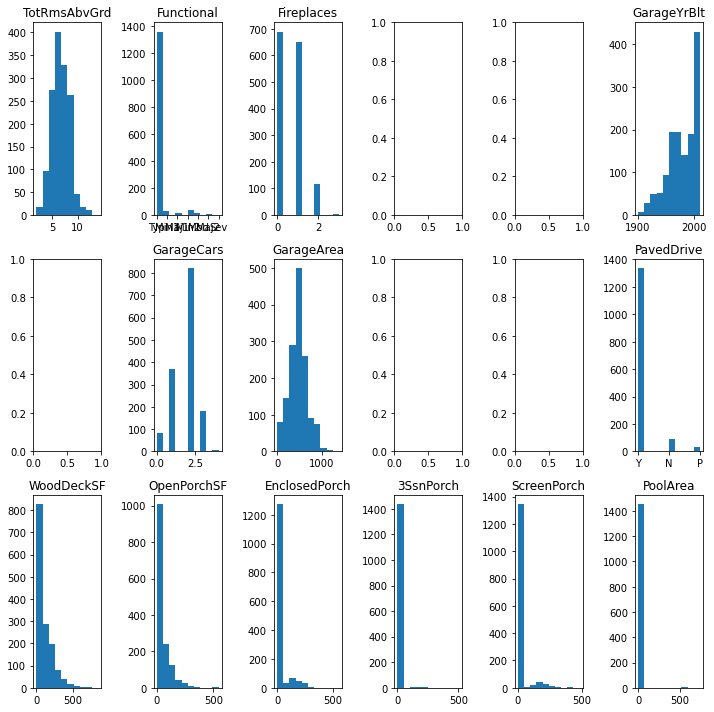

In [42]:
#fourth_cols.info()
# looks like the fireplace and garage columns have null values that need to be filled.
# Im guessing that the nulls indicate non-presence and not missing data. 
fig = plt.figure(figsize=(10,10))
for i, column in enumerate(fourth_cols.columns):
    try:
        plt.subplot(3,6,i+1)
        plt.hist(raw_data[column])
        plt.title(column)
    except:
        pass
plt.tight_layout()
plt.show()



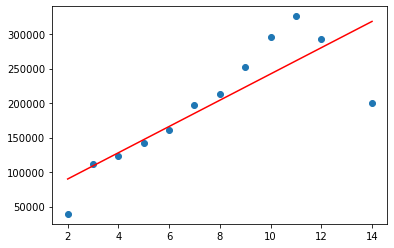

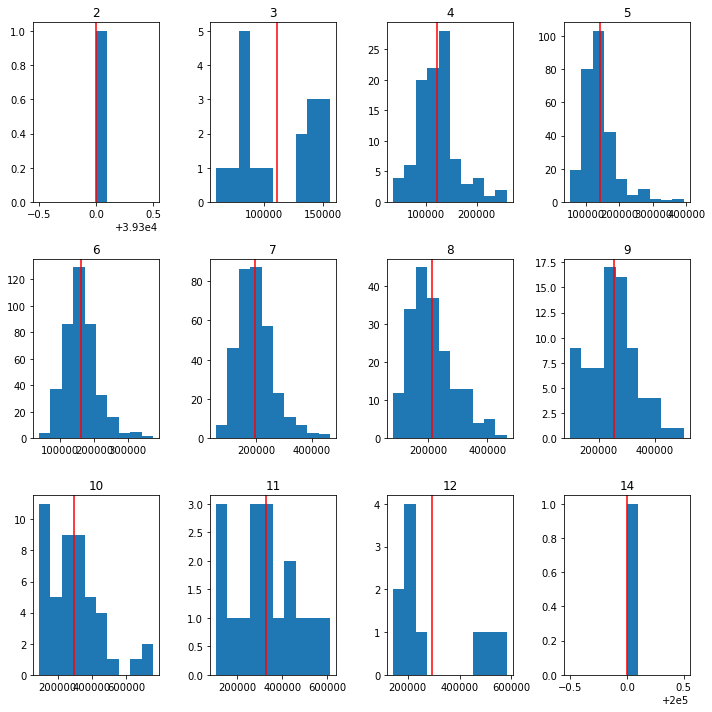

In [43]:
price_means = []
room_counts = sorted(list(raw_data['TotRmsAbvGrd'].unique()))
int_room_counts = []
for rooms in room_counts:
    room = int(rooms)
    int_room_counts.append(room)
    mask = raw_data['TotRmsAbvGrd']==rooms
    r_mean = int(raw_data["SalePrice"][mask].mean())
    price_means.append(r_mean)

x = pd.Series(int_room_counts)
y = pd.Series(price_means)
plt.scatter(x, y)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='r')

plt.show()

fig = plt.figure(figsize=(10,10))
for i, count in enumerate(room_counts):
    plt.subplot(3,4,i+1)
    mask = raw_data['TotRmsAbvGrd']==count
    plt.hist(raw_data['SalePrice'][mask])
    plt.axvline(raw_data['SalePrice'][mask].mean(), color='r')
    plt.title(count)

plt.tight_layout()
plt.show()

# room_count_price_drop = raw_data[raw_data['TotRmsAbvGrd']>11]

# even though the rooms seem to put out a linear relationship, the distribution seems way too skewed to be reliable. 
# also I think that this data is actually better captured with square footage than rooms. I'll keep it for now though

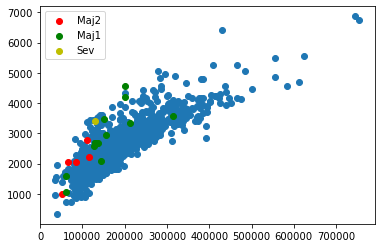

In [44]:
#looking into functional
f_counts = raw_data.Functional.value_counts()
# very skewed distribution, but if it is a huge impact then it might be worth noting
types = []
for kind in raw_data['Functional'].unique():
    if kind != 'Typ':
        types.append(kind)

mask = raw_data['Functional']=='Typ'
plt.scatter(raw_data['SalePrice'][mask], raw_data['TotalSqft'][mask])
mask = raw_data['Functional']=='Maj2'
plt.scatter(raw_data['SalePrice'][mask], raw_data['TotalSqft'][mask], color='r',label='Maj2')
mask = raw_data['Functional']=='Maj1'
plt.scatter(raw_data['SalePrice'][mask], raw_data['TotalSqft'][mask], color='g',label='Maj1')
mask = raw_data['Functional']=='Sev'
plt.scatter(raw_data['SalePrice'][mask], raw_data['TotalSqft'][mask], color='y',label='Sev')

plt.legend()

plt.show()

# not the best, but I'll do a column for disfunctionality, it seems to capture something not in the other stuff.


### looking into fireplaces

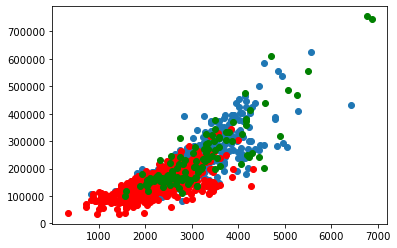

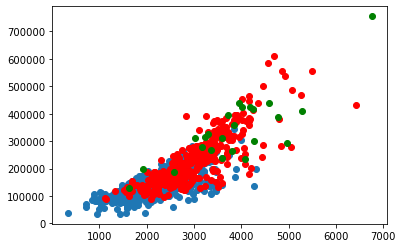

In [45]:
fourth_cols.columns
# the null values in 'FireplaceQu' are where there is no fireplace. Just change that to 'None'
raw_data[raw_data['FireplaceQu'].isnull()].shape[0] == raw_data[raw_data['Fireplaces']==0].shape[0]
raw_data['FireplaceQu'] = raw_data['FireplaceQu'].fillna('None')

# while more fireplaces tend to be higher priced, it doesnt seem to effect 

fig, ax = plt.subplots()
mask = raw_data["Fireplaces"]==1
ax.scatter(raw_data['TotalSqft'][mask], raw_data['SalePrice'][mask])
mask = raw_data["Fireplaces"]==0
ax.scatter(raw_data['TotalSqft'][mask], raw_data['SalePrice'][mask], color='r')
mask = raw_data["Fireplaces"]==2
ax.scatter(raw_data['TotalSqft'][mask], raw_data['SalePrice'][mask], color='g')

fig, ax = plt.subplots()
mask = raw_data["FireplaceQu"]=='None'
ax.scatter(raw_data['TotalSqft'][mask], raw_data['SalePrice'][mask])
mask = raw_data["FireplaceQu"]=='Gd'
ax.scatter(raw_data['TotalSqft'][mask], raw_data['SalePrice'][mask], color='r')
mask = raw_data["FireplaceQu"]=='Ex'
ax.scatter(raw_data['TotalSqft'][mask], raw_data['SalePrice'][mask], color='g')

# although fireplaces seem to be a more expensive feature, it doesnt seem to make a difference  for the regression line
# imma drop it like its hot

### looking into garage variables

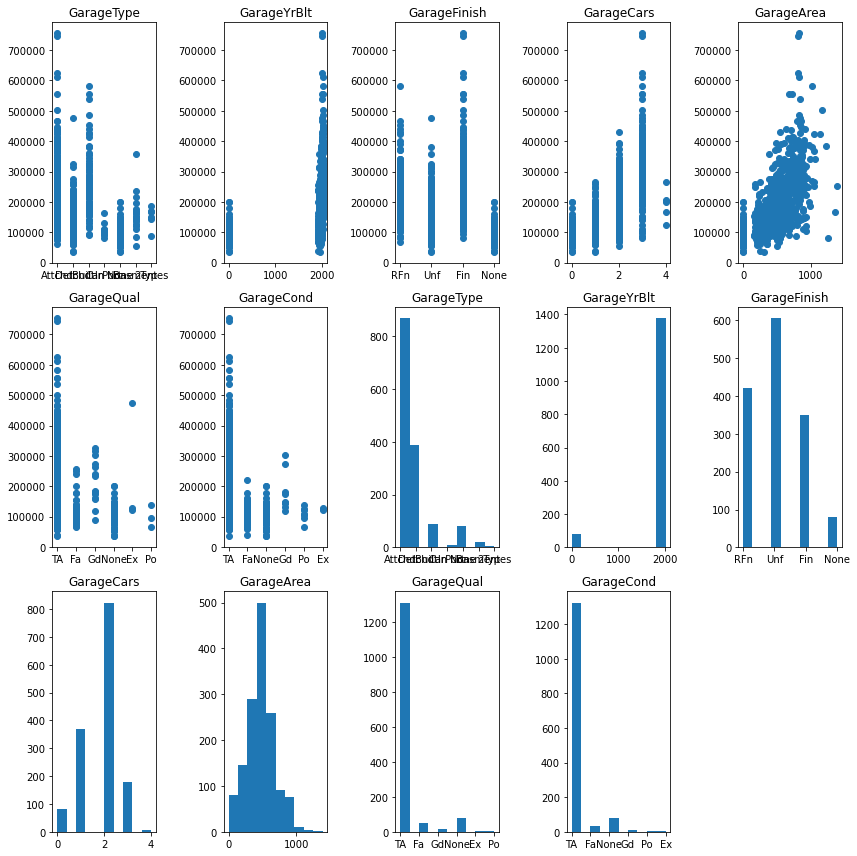

In [46]:
fourth_cols.columns
g_cols = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']
raw_data[g_cols[3]].value_counts()

# looking at number of car garage price histograms. 
# for n in raw_data['GarageCars'].unique():
#     mask = raw_data['GarageCars']==n
#     plt.hist(raw_data['SalePrice'][mask], color='c')
#     plt.axvline(raw_data['SalePrice'][mask].mean(), c='r')
#     plt.xlim(0,600000)
#     plt.title(n)
#     plt.show()


# mask =  
# plt.scatter(raw_data['GarageArea'], raw_data['SalePrice'])
# g_qual = ['TA', 'Fa', 'Gd', nan, 'Ex', 'Po']
raw_data[['GarageType', 'GarageCond',  'GarageFinish','GarageQual']] = raw_data[['GarageType', 'GarageCond',  'GarageFinish','GarageQual']].fillna(value='None', axis =1)
raw_data['GarageYrBlt'] = raw_data['GarageYrBlt'].fillna(value=0)

#plt.hist(raw_data['GarageType'])

fig = plt.figure(figsize=(12,12))
g_cats_list = ['GarageType', 'GarageCond',  'GarageFinish','GarageQual']
for i, cat in enumerate(g_cols):
    plt.subplot(3,5,i+1)
    plt.scatter(raw_data[cat], raw_data['SalePrice'])
    plt.title(cat)
    plt.subplot(3,5,i+8)
    plt.hist(raw_data[cat])
    plt.title(cat)

plt.tight_layout()    
plt.show()

# garage quality, garage condition both suck
# lets look into garage finish
# also garage area has a nice distribution, would like to see how finish correlates


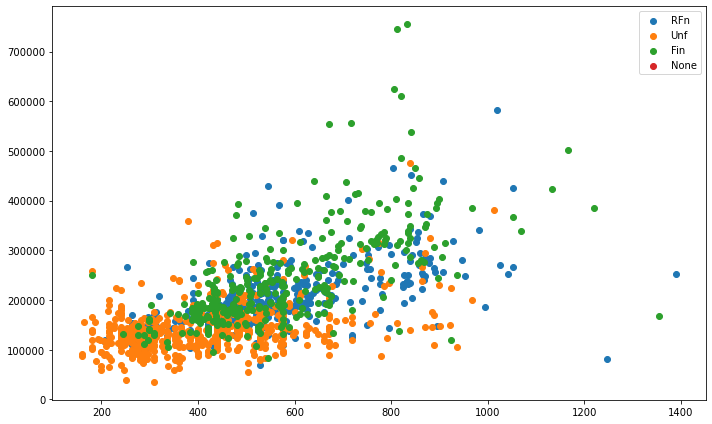

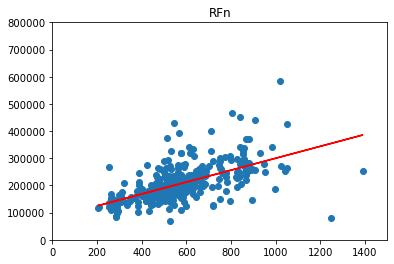

219.2530907370432


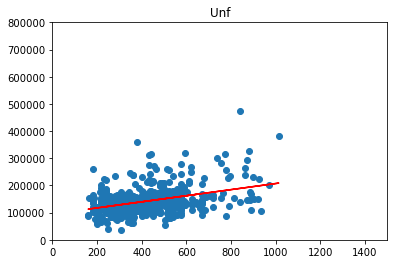

112.08142122551003


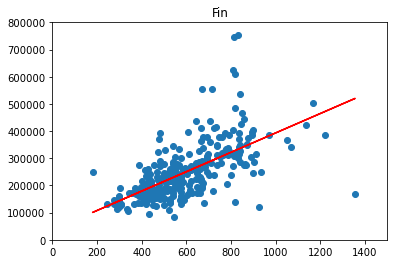

356.6749599239043


In [47]:
# plotting garage area and finish
fig = plt.figure(figsize=(10,6))
g_list = ['GarageArea', 'GarageFinish']
mask1 = raw_data['GarageArea']>0
gf_list = list(raw_data['GarageFinish'].unique())

for cat in gf_list:
    mask1 = raw_data['GarageArea']>0
    mask2 = raw_data['GarageFinish']==cat
    plt.scatter(raw_data['GarageArea'][(mask1) & (mask2)], raw_data['SalePrice'][(mask1) & (mask2)], label=cat)
    
plt.legend()
plt.tight_layout()    
plt.show()

#outliers
raw_data.loc[raw_data['GarageArea']>1200,['SalePrice', 'TotalSqft', 'Neighborhood']]
gf_list.remove('None')
for cat in gf_list:
    try:
        mask1 = raw_data['GarageArea']>0
        mask2 = raw_data['GarageFinish']==cat
        x = raw_data['GarageArea'][(mask1) & (mask2)]
        y = raw_data['SalePrice'][(mask1) & (mask2)]
        plt.scatter(x, y, label=cat)
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x + b, color='r')
        plt.xlim(0,1500)
        plt.ylim(0, 800_000)
        plt.title(cat)
        plt.show()
        print(m)
    except:
        pass
    
# BOOM! garage will be represented by 'RFGarageArea', 'UnfGarageArea', 'FinGarageArea'



### looking into paved drive and pool area

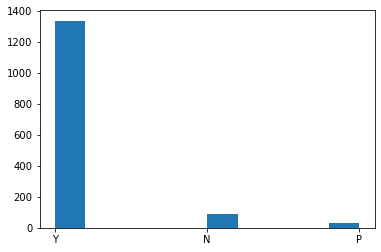

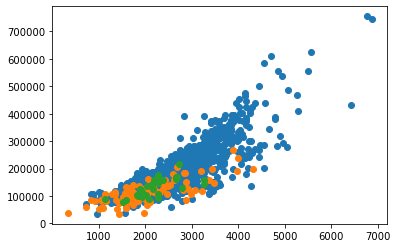

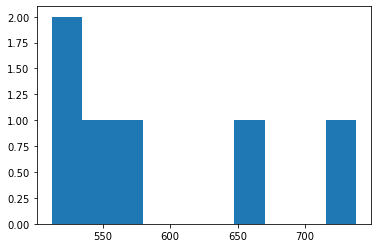

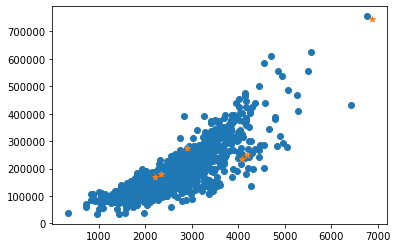

Gd    2
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [48]:

plt.hist(raw_data['PavedDrive'])
plt.show()

for category in list(raw_data['PavedDrive'].unique()):
    mask = raw_data['PavedDrive']==category
    plt.scatter(raw_data['TotalSqft'][mask], raw_data['SalePrice'][mask])
plt.show()    
# looks like paved drive might have some meaning, but the variability is so low that I dont think its worthwhile

pool_mask = raw_data['PoolArea']>0
pool_unmask = raw_data['PoolArea']==0
plt.hist(raw_data['PoolArea'][pool_mask])
plt.show()

# ONLY 6 HOUSES WITH POOLS!!! Prolly gotta drop it
pool_count = pool_mask.sum()
plt.scatter(raw_data['TotalSqft'][pool_unmask], raw_data['SalePrice'][pool_unmask])
plt.scatter(raw_data['TotalSqft'][pool_mask], raw_data['SalePrice'][pool_mask], marker='*')
plt.show()

raw_data['PoolQC'].value_counts()

#Waaaay too few pools to make it worthwhile. dropping both columns.

### Looking into Porch/Deck columns

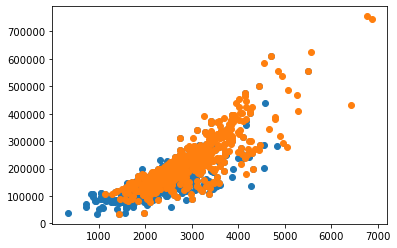

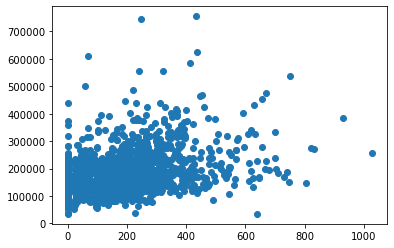

In [49]:
porch_cols = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

# histograms for deck columns
# for col in porch_cols:
#     mask = raw_data[col]>0
#     plt.hist(raw_data[col][mask])
#     plt.title(col)
#     plt.show()
    
# try to figure out the count of unique porch/deck instances
mask = (raw_data['WoodDeckSF']>0) | (raw_data['OpenPorchSF']>0) | (raw_data['EnclosedPorch']>0) | (raw_data['3SsnPorch']>0) | (raw_data['ScreenPorch']>0)
m_ask = (raw_data['WoodDeckSF']>300) | (raw_data['OpenPorchSF']>raw_data['OpenPorchSF'].mean())
unmask = raw_data['WoodDeckSF']==0
plt.scatter(raw_data['TotalSqft'][unmask], raw_data["SalePrice"][unmask])
plt.scatter(raw_data['TotalSqft'][m_ask], raw_data["SalePrice"][m_ask])
plt.show()

#add porch/deck columns together
raw_data['PorchArea'] = raw_data[porch_cols].sum(axis=1)

plt.scatter(raw_data['PorchArea'], raw_data["SalePrice"])
plt.show()

# I dont think that this category is linear enough to make any correlations, but lets combine them anyway and see what happens

## Fourth Column Function part
- leaving room count, but probably should drop it later
- changing 'Functional' to just pick up the bottom 3 categorical variables
- dropping fireplace stuff, pool stuff, paved drive
- compressing garage area and finish together to create 3 columns with area for each finish type
- combining all the porch/deck area columns


In [50]:
# changing functional to just pick up the bottom 3 variables
def functionality(df):
    functionality_dict = {'Typ':0, 'Mod':0, 'Min2':0, 'Min1':0, 'Maj1':1, 'Maj2':1, 'Sev':1}
    df['Disfunctional'] = df['Functional'].replace(to_replace=functionality_dict)
    df = df.drop('Functional', axis=1)
    return df

# drop columns
def to_drop(df):
    drop_cols = ['Fireplaces', 'FireplaceQu', 'PoolArea', 'PoolQC', 'PavedDrive']
    df = df.drop(labels=drop_cols, axis=1)
    return df

# garage cols
def garage_transformation(df):
    df['RFGarageArea'] = 0
    df['UnfGarageArea'] = 0
    df['FinGarageArea'] = 0
    df.loc[(df['GarageFinish'] == 'RFn'), 'RFGarageArea'] = df['GarageArea']
    df.loc[(df['GarageFinish'] == 'Unf'), 'UnfGarageArea'] = df['GarageArea']
    df.loc[(df['GarageFinish'] == 'Fin'), 'FinGarageArea'] = df['GarageArea']
    df = df.drop(labels=['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond'], axis=1)
    return df

# combining deck/porch columns for a total deck area
def combine_deck_types(df):
    porch_cols = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
    df['DeckArea'] = df[porch_cols].sum(axis=1)
    df=df.drop(labels = porch_cols, axis=1)
    return df

#data = functionality(data)
data = to_drop(data)
data = garage_transformation(data)
data = combine_deck_types(data)

data.head()


,Neighborhood,OverallQual,OverallCond,Foundation,BsmtQual,BsmtFinSF1,TotRmsAbvGrd,Functional,Fence,MiscFeature,...,YrsSinceRemod,CombinedBaths,TotalSqft,ExcHeating,ExcKitchen,GoodKitchen,RFGarageArea,UnfGarageArea,FinGarageArea,DeckArea
0,average_area,7,5,PConc,Gd,706,8,Typ,NaN,NaN,...,5,3.5,2566,1,0,1,548,0,0,61
1,average_area,6,8,CBlock,Gd,978,6,Typ,NaN,NaN,...,31,2.5,2524,1,0,0,460,0,0,298
2,average_area,7,5,PConc,Gd,486,6,Typ,NaN,NaN,...,6,3.5,2706,1,0,1,608,0,0,42
3,average_area,7,5,Other,TA,216,7,Typ,NaN,NaN,...,36,2.0,2473,0,0,1,0,642,0,307
4,nice_area,8,5,PConc,Gd,655,9,Typ,NaN,NaN,...,8,3.5,3343,1,0,1,836,0,0,276


## Looking into the fifth set of columns

this last set of columns pretty much ruined me on this dataset. Fence and MiscFeature are virtually worthless, and the rest of the columns would be thrown out for data leakage under normal circumstances. However, for this particular contest we arent making pure predictions for unknown future values since the test set has an array of mixed dates similar to the training set. This fact would encourage us to use the date and probably conditions of the sale to help predict values because those values do in fact have some bearing on the target value. So I am just going to drop these last few columns and wrap up this analysis with a simple linear regression model and a Kaggle submission for feedback and to complete this review. 

## Fifth col function part -incomplete-

In [51]:
# Just gonna drop this without much analysis right now
def drop_to_get_this_done(df):
    drop_cols = ['Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition']
    df = df.drop(labels=drop_cols, axis=1)
    return df

def get_dummies(df):
    dummy_cols = list(df.select_dtypes(include='object').columns)
    dummies = pd.get_dummies(df[dummy_cols],prefix=dummy_cols)
    df = pd.concat([df,dummies],axis=1)
    df = df.drop(labels=dummy_cols, axis=1)
    
    return df

data = drop_to_get_this_done(data)
data = get_dummies(data)



# Turning the data into simple Linear Regression Prediction

In [52]:
train_y = data['SalePrice']
train_X = data.drop('SalePrice', axis = 1)

lr = LinearRegression()

cv(lr, train_X, train_y, cv=5).mean()

0.8745329573697109

In [53]:
train_X.shape

(1458, 32)

In [54]:
# training the model to make some predictions
model = lr.fit(train_X, train_y)
model

LinearRegression()

#### quickly taking a look how the model predicitions work with the training data

In [55]:
preds = model.predict(train_X)
error = mse(train_y, preds)
rmse = error**.5
f"rmse = {rmse}"

'rmse = 27120.568873331667'

In [56]:
# import the testing data
test = pd.read_csv('test.csv')
test.head()
test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# function summary to transform test data

In [57]:
# dropping unwanted columns
def drop_unwanted_columns(df):
    drop_cols = ['Id', 'MSSubClass', 'LotFrontage', 'LotArea','MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',\
                 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',\
                 'RoofMatl', 'Exterior1st', 'Exterior2nd','MasVnrArea', 'MasVnrType', 'ExterCond', 'ExterQual',\
                 'BsmtFinType1', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF',\
                 'KitchenAbvGr', 'BedroomAbvGr', 'BsmtFinSF2','Heating', 'CentralAir', 'Electrical', 'GrLivArea',\
                 'Fireplaces', 'FireplaceQu', 'PoolArea', 'PoolQC', 'PavedDrive']
    df = df.drop(labels=drop_cols, axis=1)
    return df


# creating neighborhood:area dictionary
neighborhood_dict = {'NAmes': 'poor_area', 'CollgCr': 'average_area', 'OldTown': 'poor_area', 'Edwards': 'poor_area',\
                     'Somerst': 'average_area', 'Gilbert': 'average_area', 'NridgHt': 'nice_area', 'Sawyer': 'poor_area',\
                     'NWAmes': 'average_area', 'SawyerW': 'average_area', 'BrkSide': 'poor_area', 'Crawfor': 'average_area',\
                     'Mitchel': 'poor_area', 'NoRidge': 'nice_area', 'Timber': 'average_area', 'IDOTRR': 'poor_area',\
                     'ClearCr': 'average_area', 'StoneBr': 'nice_area', 'SWISU': 'poor_area', 'MeadowV': 'poor_area',\
                     'Blmngtn': 'average_area', 'BrDale': 'poor_area', 'Veenker': 'average_area', 'NPkVill': 'poor_area',\
                     'Blueste': 'poor_area'}

# map areas onto neighborhood column
def bin_neighborhoods(df):
    df['Neighborhood'] = df['Neighborhood'].replace(to_replace=neighborhood_dict)
    return df

# turning 'YearBuilt' into Age
def year_to_age(df):
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df = df.drop('YearBuilt', axis=1)
    return df

# turning 'YearRemodAdd' int 'YrsSinceRemod'
def year_remod_to_yrs_since(df):
    df['YrsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
    df = df.drop('YearRemodAdd', axis=1)
    return df

# combining foundation categoricals
def combine_foundation_categories(df):
    mask = (df['Foundation']!='PConc') & (df['Foundation']!='CBlock')
    df.loc[mask, 'Foundation'] = 'Other'
    return df

# adding up the bathrooms
def combine_baths(df):
    df[['BsmtFullBath', 'BsmtHalfBath']] = df[['BsmtFullBath', 'BsmtHalfBath']].fillna(value=0)
    df["CombinedBaths"] =  df['BsmtFullBath'] + (df['BsmtHalfBath']*.5) + df['FullBath'] + (df['HalfBath']*.5)
    df = df.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], axis=1)
    return df

# adding up all the square footage
def adding_sqft(df):
    df[['TotalBsmtSF', 'BsmtFinSF1']] = df[['TotalBsmtSF', 'BsmtFinSF1']].fillna(value=0)
    df['TotalSqft'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']
    df = df.drop(['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF'], axis=1)
    return df

# create binary column for excellent heating
heat_qc_values = list(raw_data['HeatingQC'].unique())
new_col_values = [1,0,0,0,0]
heat_qc_dict = dict(zip(heat_qc_values, new_col_values))

def exc_heating(df):
    df['ExcHeating'] = df['HeatingQC'].replace(to_replace=heat_qc_dict)
    df = df.drop(['HeatingQC'], axis=1)
    return df

# create "kitchen quality" cols for good and excellent
def kitchen_classifier(df):
    df['ExcKitchen'] = 0
    df['GoodKitchen'] = 0
    df.loc[df['KitchenQual']=='Gd','GoodKitchen'] = 1
    df.loc[df['KitchenQual']=='Ex','ExcKitchen'] = 1
    df = df.drop(labels='KitchenQual', axis=1)
    return df

# garage cols
def garage_transformation(df):
    df['RFGarageArea'] = 0
    df['UnfGarageArea'] = 0
    df['FinGarageArea'] = 0
    df.loc[(df['GarageFinish'] == 'RFn'), 'RFGarageArea'] = df['GarageArea']
    df.loc[(df['GarageFinish'] == 'Unf'), 'UnfGarageArea'] = df['GarageArea']
    df.loc[(df['GarageFinish'] == 'Fin'), 'FinGarageArea'] = df['GarageArea']
    df = df.drop(labels=['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',\
                         'GarageCond'], axis=1)
    return df

# combining deck/porch columns for a total deck area
def combine_deck_types(df):
    porch_cols = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
    df['DeckArea'] = df[porch_cols].sum(axis=1)
    df=df.drop(labels = porch_cols, axis=1)
    return df

# Just gonna drop this without much analysis right now
def drop_to_get_this_done(df):
    drop_cols = ['Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold',
       'SaleType', 'SaleCondition']
    df = df.drop(labels=drop_cols, axis=1)
    return df

def get_dummies(df):
    dummy_cols = list(df.select_dtypes(include='object').columns)
    dummies = pd.get_dummies(df[dummy_cols],prefix=dummy_cols)
    df = pd.concat([df,dummies],axis=1)
    df = df.drop(labels=dummy_cols, axis=1)
    
    return df



# processing & transforming data
def process_data(data):
    data = drop_unwanted_columns(data)
    data = bin_neighborhoods(data)
    data = year_to_age(data)
    data = year_remod_to_yrs_since(data)
    data = combine_foundation_categories(data)
    data = combine_baths(data)
    data = adding_sqft(data)
    data = exc_heating(data)
    data = kitchen_classifier(data)
    data = garage_transformation(data)
    data = combine_deck_types(data)
    data = drop_to_get_this_done(data)
    data = get_dummies(data)

    return data

test_X = process_data(test)

# double checking the columns and looking for null values
test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OverallQual                1459 non-null   int64  
 1   OverallCond                1459 non-null   int64  
 2   BsmtFinSF1                 1459 non-null   float64
 3   TotRmsAbvGrd               1459 non-null   int64  
 4   Age                        1459 non-null   int64  
 5   YrsSinceRemod              1459 non-null   int64  
 6   CombinedBaths              1459 non-null   float64
 7   TotalSqft                  1459 non-null   float64
 8   ExcHeating                 1459 non-null   int64  
 9   ExcKitchen                 1459 non-null   int64  
 10  GoodKitchen                1459 non-null   int64  
 11  RFGarageArea               1459 non-null   float64
 12  UnfGarageArea              1459 non-null   float64
 13  FinGarageArea              1459 non-null   float

### Making the Kaggle submission

In [58]:
def assembling_predictions(model, data):
    
    predictions = model.predict(data)
    
    test_id = test['Id']
    
    #dictionary for dataframe format
    d = {'Id': test_id,
        'SalePrice': predictions}
    
    best_guesses = pd.DataFrame(data=d)
    return best_guesses


sub = assembling_predictions(model, test_X)
sub

,Id,SalePrice
0,1461,119446.846295
1,1462,173324.962752
2,1463,180478.881412
3,1464,205198.165515
4,1465,222077.625941
...,...,...
1454,2915,85582.166308
1455,2916,82788.072676
1456,2917,181083.206955
1457,2918,105548.817454


In [59]:
def create_submission(df, filename='submission.csv'):
    df.to_csv(filename, index=False)
    
#create_submission(sub)


# Conclusions

While I am not thrilled with the actual results from this submission, and I wish that I had chosen a different machine learning competition to cut my teeth on, going through the process of developing an approach to making these predictions from start to finish by myself I learned a ton about practical data processing and while I dont cover it in this notebook, I found out just how many amazing tools are available for each phase of data processing and model building in the SciKitLearn library. I will definitely be exploring more of those concepts in another notebook including feature selection, scaling and normalization, model selection, different cross-validation techniques and using pipelines to streamline the entire process and minimize chances for error. 

